In [20]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(1)

In [21]:
# Loading the dataset
#X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
train_orig = pd.read_csv('train.csv')
test_orig = pd.read_csv('test.csv')
print('Train set shape:',  train_orig.shape)
print('Test set shape:',  test_orig.shape)

Train set shape: (42000, 785)
Test set shape: (28000, 784)


In [22]:
X_train_orig = train_orig.iloc[:,1:]
Y_train_orig = train_orig.iloc[:,0]
X_test_orig = test_orig

X_train_orig.shape, Y_train_orig.shape, X_test_orig.shape

((42000, 784), (42000,), (28000, 784))

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_orig, Y_train_orig, test_size=0.20, random_state=42)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [24]:
# Normalize features
X_train = X_train.T/255.
X_val = X_val.T/255.
X_test = X_test_orig.T/255.
# One-hot encode labels
Y_train = pd.get_dummies(Y_train).T
Y_val = pd.get_dummies(Y_val).T

In [25]:
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of validation examples = " + str(X_val.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 33600
number of validation examples = 8400
number of test examples = 28000
X_train shape: (784, 33600)
X_val shape: (784, 8400)
Y_train shape: (10, 33600)
Y_val shape: (10, 8400)
X_test shape: (784, 28000)


In [26]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name='Y')
    
    return X, Y

In [35]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)
        
    W1 = tf.get_variable('W1', [100, 784], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [100,1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable('W2', [50,100], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [50,1], initializer= tf.zeros_initializer())
    W3 = tf.get_variable('W3', [10,50], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [10,1], initializer= tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [28]:
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1, X) + b1                    # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                           # A1 = relu(Z1)
    A1 = tf.nn.dropout(A1, keep_prob)
    Z2 = tf.matmul(W2, A1) + b2                   # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                           # A2 = relu(Z2)
    A2 = tf.nn.dropout(A2, keep_prob)
    Z3 = tf.matmul(W3, A2) + b3                   # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [29]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [30]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [31]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [784, None])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [32]:
def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [33]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 700, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y:minibatch_Y, 
                                                                            keep_prob:0.8})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, keep_prob:1.0}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, keep_prob:1.0}))
        
        return parameters

Cost after epoch 0: 1.115009


Cost after epoch 100: 0.030470


Cost after epoch 200: 0.013285


Cost after epoch 300: 0.011700


Cost after epoch 400: 0.008449


Cost after epoch 500: 0.006801


Cost after epoch 600: 0.005505


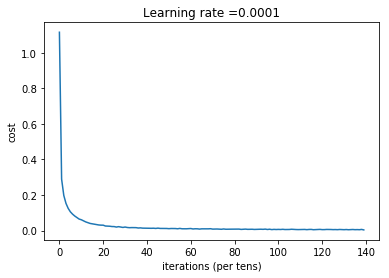

Parameters have been trained!


Train Accuracy: 1.0
Test Accuracy: 0.972262


In [36]:
parameters = model(X_train.values, Y_train.values, X_val.values, Y_val.values)

Although the neural network is clearly overfitting the training set, by adding dropout to the layers, I could increase the accuracy from 94% to 97%. Keeping in mind, that this is a "normal", densely connected network without convolution, it is a very good result. I expect that a convolutional NN would be able to reach a higher accuracy.

In [37]:
prediction = predict(X_test, parameters)

In [38]:
prediction

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [39]:
submission = pd.DataFrame(columns=['ImageId','Label'])
submission['ImageId'] = list(range(1, X_test.shape[1]+1))
submission['Label'] = prediction

In [40]:
submission.to_csv('submission3.csv', index=False)

In [41]:
print('Result from Kaggle was: Your submission scored 0.97114')

Result from Kaggle was: Your submission scored 0.97114
